In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt


In [2]:
#Inflate variant effect predictions from h5 file

def inflate_snp_predictions(pos_or_neg, fold_index=[0, 1, 2, 3], fold_suffixes=['', '', '', '']) :

    print("Inflating predictions for '" + pos_or_neg + "'.")
    
    df_folds = []

    #Loop over folds
    for fold_ix, fold_suffix in zip(fold_index, fold_suffixes) :

        #Load file
        sed = h5py.File('test_paqtl/f' + str(fold_ix) + 'c0' + fold_suffix + '/paqtl_pip90/merge_' + pos_or_neg + '/sed.h5', 'r')
        
        gene_id_mat = sed['gene'][()]
        snp_mat = sed['snp'][()]
        chr_mat = sed['chr'][()]
        pos_mat = sed['pos'][()]
        n_mat = sed['n'][()]
        dist_mat = sed['distance'][()]
        covr_mat = sed['COVR'][()]
        ref_allele_mat = sed['ref_allele'][()]
        alt_allele_mat = sed['alt_allele'][()]

        gene_ids = []
        snps = []
        chroms = []
        poses = []
        ns = []
        distances = []
        covr_preds = []
        ref_alleles = []
        alt_alleles = []

        #Loop over SNP rows
        for i, si in enumerate(sed['si'][()].tolist()) :

            gene_ids.append(gene_id_mat[i].decode())
            snps.append(snp_mat[si].decode())
            chroms.append(chr_mat[si].decode())
            poses.append(int(pos_mat[si]))
            ns.append(int(n_mat[i]))
            distances.append(int(dist_mat[i]))

            #Average prediction across tissues
            covr_preds.append(np.mean(covr_mat[i, :]))

            ref_alleles.append(ref_allele_mat[si].decode())
            alt_alleles.append(alt_allele_mat[si].decode())

        #Create dataframe
        df = pd.DataFrame({
            'gene_id_pred' : gene_ids,
            'snp' : snps,
            'chrom' : chroms,
            'pos' : poses,
            'n' : ns,
            'min_dist_pred' : distances,
            'delta_score' : covr_preds,
        })

        print("len(df) = " + str(len(df)))

        df_folds.append(df)

    df = df_folds[0]
    df = df.rename(columns={'delta_score' : 'delta_score_0'})
    df['delta_score'] = df['delta_score_0']
    
    #Loop over folds and average across
    for i in range(1, len(df_folds)) :

        df['delta_score_' + str(i)] = df_folds[i]['delta_score']
        df['delta_score'] += df['delta_score_' + str(i)]
        
    df['delta_score'] /= float(len(df_folds))
    
    #Get finemapped gene id and distance
    vcf_df = pd.read_csv('/home/jlinder/seqnn/data/qtl_cat/paqtl_pip90ea/' + pos_or_neg + '_merge.vcf', sep='\t', skiprows=4)
    
    vcf_df['min_dist'] = vcf_df['INFO'].apply(lambda x: x.split(";PD=")[1].split(";PI=")[0]).astype(int)
    vcf_df['finemap_gene_id'] = vcf_df['INFO'].apply(lambda x: x.split("MT=")[1].split(".")[0])
    vcf_df['matched_snp'] = vcf_df['INFO'].apply(lambda x: x.split("PI=")[1])
    
    df = df.join(vcf_df[['ID', 'min_dist', 'finemap_gene_id', 'matched_snp']].set_index('ID'), on='snp', how='inner').copy().reset_index(drop=True)
    
    df.loc[df['delta_score'].isnull(), 'delta_score'] = 0.
    
    return df

df_snp_pos = inflate_snp_predictions('pos', [0, 1, 2, 3], ['', '', '', ''])
df_snp_neg = inflate_snp_predictions('neg', [0, 1, 2, 3], ['', '', '', ''])

#Rename borzoi VEP score
df_snp_pos = df_snp_pos.rename(columns={'delta_score' : 'delta_score_borzoi'})
df_snp_neg = df_snp_neg.rename(columns={'delta_score' : 'delta_score_borzoi'})


Inflating predictions for 'pos'.
len(df) = 10704
len(df) = 10704
len(df) = 10704
len(df) = 10704
Inflating predictions for 'neg'.
len(df) = 30959
len(df) = 30959
len(df) = 30959
len(df) = 30959


In [3]:
#Show statistics for example SNP

df_snp_pos.query("snp == 'chr14_57290084_G_A'")


,gene_id_pred,snp,chrom,pos,n,min_dist_pred,delta_score_0,delta_score_borzoi,delta_score_1,delta_score_2,delta_score_3,min_dist,finemap_gene_id,matched_snp
1954,ENSG00000070367.16,chr14_57290084_G_A,chr14,57290084,27,81740,0.002279,0.002037,0.002075,0.002342,0.001452,10,ENSG00000053770,chr14_57290084_G_A
1955,ENSG00000053770.12,chr14_57290084_G_A,chr14,57290084,16,10,1.049805,1.041992,1.011719,1.288086,0.816895,10,ENSG00000053770,chr14_57290084_G_A
1956,ENSG00000139977.14,chr14_57290084_G_A,chr14,57290084,20,119629,0.004410,0.004040,0.003510,0.006813,0.001427,10,ENSG00000053770,chr14_57290084_G_A
1957,ENSG00000100557.10,chr14_57290084_G_A,chr14,57290084,2,179220,0.001740,0.001821,0.002800,0.002071,0.000673,10,ENSG00000053770,chr14_57290084_G_A


In [4]:
#Filter on matched gene

df_snp_pos['gene_id_base'] = df_snp_pos['gene_id_pred'].apply(lambda x: x.split(".")[0])
df_snp_neg['gene_id_base'] = df_snp_neg['gene_id_pred'].apply(lambda x: x.split(".")[0])

df_snp_pos = df_snp_pos.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)


In [5]:
#Show statistics for example SNP (after filtering)

df_snp_pos.query("snp == 'chr14_57290084_G_A'")


,gene_id_pred,snp,chrom,pos,n,min_dist_pred,delta_score_0,delta_score_borzoi,delta_score_1,delta_score_2,delta_score_3,min_dist,finemap_gene_id,matched_snp,gene_id_base
170,ENSG00000053770.12,chr14_57290084_G_A,chr14,57290084,16,10,1.049805,1.041992,1.011719,1.288086,0.816895,10,ENSG00000053770,chr14_57290084_G_A,ENSG00000053770


In [6]:
#Sort by SNP

df_snp_pos = df_snp_pos.sort_values(by=['snp'], ascending=True).copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.sort_values(by=['snp'], ascending=True).copy().reset_index(drop=True)


n pos = 703
n neg = 2978


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


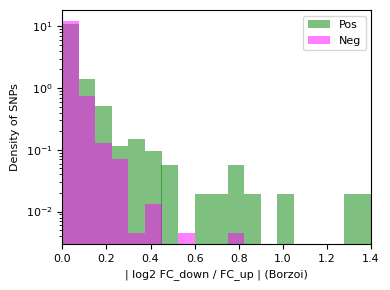

In [7]:
#Plot distribution of SNP effect sizes (for cis-regulatory PAS SNPs only, <= 2000 bp)

import matplotlib.pyplot as plt

filter_query = "min_dist <= 2000"

pos_score = np.clip(np.abs(df_snp_pos.query(filter_query)['delta_score_borzoi'].values), 0.0, 1.5)
neg_score = np.clip(np.abs(df_snp_neg.query(filter_query)['delta_score_borzoi'].values), 0.0, 1.5)

print("n pos = " + str(pos_score.shape[0]))
print("n neg = " + str(neg_score.shape[0]))

f = plt.figure(figsize=(4, 3))

plt.hist(pos_score, bins=20, color='green', range=(0.0, 1.5), density=True, log=True, alpha=0.5, label='Pos')
plt.hist(neg_score, bins=20, color='magenta', range=(0.0, 1.5), density=True, log=True, alpha=0.5, label='Neg')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel("| log2 FC_down / FC_up | (Borzoi)", fontsize=8)
plt.ylabel("Density of SNPs", fontsize=8)

plt.xlim(0.0, 1.4)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig("borzoi_paqtl_v2_pip90_bench_covr_histo.png", transparent=False, dpi=300)
plt.savefig("borzoi_paqtl_v2_pip90_bench_covr_histo.eps")

plt.show()


n pos = 1058
n neg = 4037


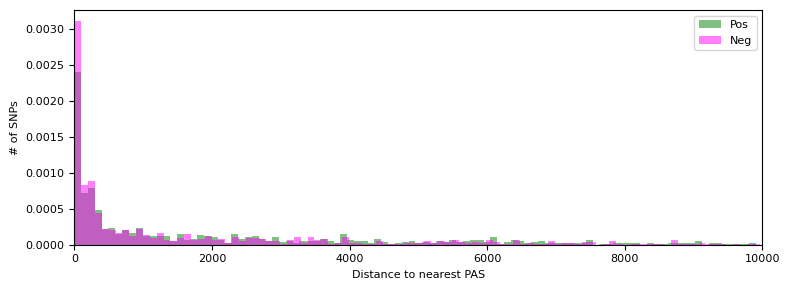

In [8]:
#Plot distribution of SNP distances to PASs

filter_query = "min_dist <= 10000"

pos_dist = df_snp_pos.query(filter_query)['min_dist'].values
neg_dist = df_snp_neg.query(filter_query)['min_dist'].values

print("n pos = " + str(pos_dist.shape[0]))
print("n neg = " + str(neg_dist.shape[0]))

f = plt.figure(figsize=(8, 3))

plt.hist(pos_dist, bins=100, color='green', density=True, alpha=0.5, label='Pos')
plt.hist(neg_dist, bins=100, color='magenta', density=True, alpha=0.5, label='Neg')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel("Distance to nearest PAS", fontsize=8)
plt.ylabel("# of SNPs", fontsize=8)

plt.xlim(0, 10000)

plt.legend(fontsize=8)

plt.tight_layout()

plt.show()


- n pos = 1021
- n neg = 1021
- n sample = 816
- n pos = 679
- n neg = 679
- n sample = 543
- n pos = 465
- n neg = 465
- n sample = 372
- n pos = 394
- n neg = 394
- n sample = 315
- n pos = 313
- n neg = 313
- n sample = 250
- n pos = 240
- n neg = 240
- n sample = 192
- n pos = 166
- n neg = 166
- n sample = 132


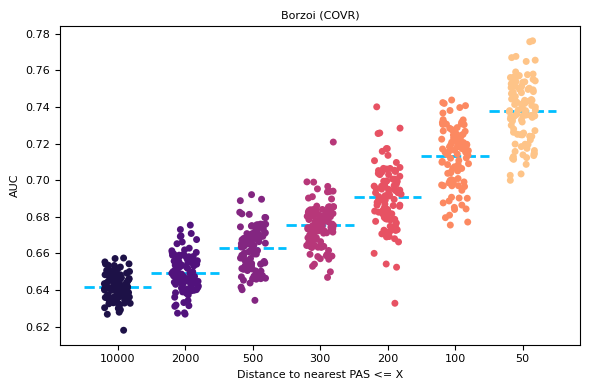

In [9]:
#Evaluate SNP classification performance based on scalar effect size predictions, as a function of SNP-PAS distance

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

frac_sample = 0.8
n_shuffles = 100
min_distances = [10000, 2000, 500, 300, 200, 100, 50]

auc_mat = np.zeros((len(min_distances), n_shuffles))

#Loop over distance thresholds
for min_dist_ix, min_dist in enumerate(min_distances) :
    
    filter_query = "min_dist <= " + str(min_dist)

    df_snp_pos['is_causal'] = 1
    df_snp_neg['is_causal'] = 0

    #Select only SNPs within distance threshold
    df_snp_pos_filtered = df_snp_pos.query(filter_query)
    df_snp_neg_filtered = df_snp_neg.query(filter_query)

    shuffle_index_pos = np.arange(len(df_snp_pos_filtered))
    shuffle_index_neg = np.arange(len(df_snp_neg_filtered))

    aucs = []

    #Loop over perturbation indices
    for shuffle_ix in range(n_shuffles) :

        np.random.shuffle(shuffle_index_pos)
        np.random.shuffle(shuffle_index_neg)
        
        #Get perturbation sample
        df_snp_pos_shuffled = df_snp_pos_filtered.iloc[shuffle_index_pos].copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_filtered.iloc[shuffle_index_neg].copy().reset_index(drop=True)
        
        #Select unique matched IDs
        df_snp_pos_shuffled = df_snp_pos_shuffled.drop_duplicates(subset=['snp'], keep='first').copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_shuffled.drop_duplicates(subset=['matched_snp'], keep='first').copy().reset_index(drop=True)

        df_snp_pos_shuffled = df_snp_pos_shuffled.loc[df_snp_pos_shuffled['snp'].isin(df_snp_neg_shuffled['matched_snp'])].copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_shuffled.loc[df_snp_neg_shuffled['matched_snp'].isin(df_snp_pos_shuffled['snp'])].copy().reset_index(drop=True)

        if shuffle_ix == 0 :
            print("- n pos = " + str(len(df_snp_pos_shuffled)))
            print("- n neg = " + str(len(df_snp_neg_shuffled)))

        n_min = min(len(df_snp_pos_shuffled), len(df_snp_neg_shuffled))
        n_sample = int(frac_sample * n_min)

        if shuffle_ix == 0 :
            print("- n sample = " + str(n_sample))

        df_snp = pd.concat([df_snp_pos_shuffled.iloc[:n_sample], df_snp_neg_shuffled.iloc[:n_sample]])

        score = np.abs(np.array(df_snp['delta_score_borzoi'].values))
        label = np.array(df_snp['is_causal'].values)

        #AUC score
        fpr, tpr, _ = roc_curve(label, score)

        auc = roc_auc_score(label, score)
        aucs.append(auc)
    
    auc_mat[min_dist_ix, :] = np.array(aucs)

#Plot AUC scores
import seaborn as sns

f = plt.figure(figsize=(6, 4))

sns.stripplot(data=[auc_mat[i, :] for i in range(auc_mat.shape[0])], jitter=0.2, palette='magma')

for i in range(auc_mat.shape[0]) :
    plt.plot([i-0.5, i+0.5], [np.mean(auc_mat[i, :]), np.mean(auc_mat[i, :])], color='deepskyblue', linewidth=2, linestyle='--')

plt.xticks(np.arange(len(min_distances)), min_distances, fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel("Distance to nearest PAS <= X", fontsize=8)
plt.ylabel("AUC", fontsize=8)

plt.title("Borzoi (COVR)", fontsize=8)

plt.tight_layout()

plt.savefig("borzoi_paqtl_v2_pip90_cov_permuted_auc.png", dpi=300, transparent=True)
plt.savefig("borzoi_paqtl_v2_pip90_cov_permuted_auc.eps")

plt.show()


- n pos = 1021
- n neg = 1021
- n sample = 816
- n pos = 679
- n neg = 679
- n sample = 543
- n pos = 465
- n neg = 465
- n sample = 372
- n pos = 394
- n neg = 394
- n sample = 315
- n pos = 313
- n neg = 313
- n sample = 250
- n pos = 240
- n neg = 240
- n sample = 192
- n pos = 166
- n neg = 166
- n sample = 132


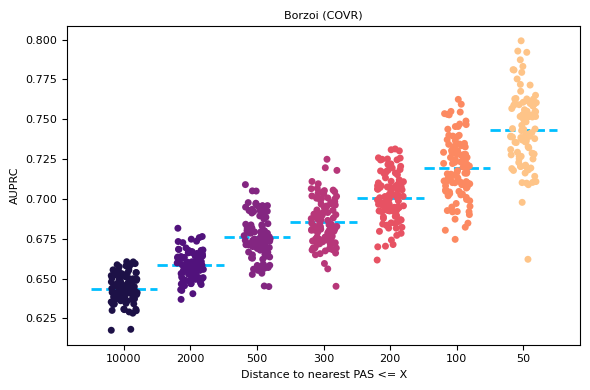

In [10]:
#Evaluate SNP classification performance based on scalar effect size predictions, controlling for SNP-PAS distance (APRs)

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

frac_sample = 0.8
n_shuffles = 100
min_distances = [10000, 2000, 500, 300, 200, 100, 50]

ap_mat = np.zeros((len(min_distances), n_shuffles))

#Loop over distance thresholds
for min_dist_ix, min_dist in enumerate(min_distances) :
    
    filter_query = "min_dist <= " + str(min_dist)

    df_snp_pos['is_causal'] = 1
    df_snp_neg['is_causal'] = 0

    #Select only SNPs within distance threshold
    df_snp_pos_filtered = df_snp_pos.query(filter_query)
    df_snp_neg_filtered = df_snp_neg.query(filter_query)

    shuffle_index_pos = np.arange(len(df_snp_pos_filtered))
    shuffle_index_neg = np.arange(len(df_snp_neg_filtered))

    aps = []

    #Loop over perturbation indices
    for shuffle_ix in range(n_shuffles) :

        np.random.shuffle(shuffle_index_pos)
        np.random.shuffle(shuffle_index_neg)
        
        #Get perturbation sample
        df_snp_pos_shuffled = df_snp_pos_filtered.iloc[shuffle_index_pos].copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_filtered.iloc[shuffle_index_neg].copy().reset_index(drop=True)
        
        #Select unique matched IDs
        df_snp_pos_shuffled = df_snp_pos_shuffled.drop_duplicates(subset=['snp'], keep='first').copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_shuffled.drop_duplicates(subset=['matched_snp'], keep='first').copy().reset_index(drop=True)

        df_snp_pos_shuffled = df_snp_pos_shuffled.loc[df_snp_pos_shuffled['snp'].isin(df_snp_neg_shuffled['matched_snp'])].copy().reset_index(drop=True)
        df_snp_neg_shuffled = df_snp_neg_shuffled.loc[df_snp_neg_shuffled['matched_snp'].isin(df_snp_pos_shuffled['snp'])].copy().reset_index(drop=True)

        if shuffle_ix == 0 :
            print("- n pos = " + str(len(df_snp_pos_shuffled)))
            print("- n neg = " + str(len(df_snp_neg_shuffled)))

        n_min = min(len(df_snp_pos_shuffled), len(df_snp_neg_shuffled))
        n_sample = int(frac_sample * n_min)

        if shuffle_ix == 0 :
            print("- n sample = " + str(n_sample))

        df_snp = pd.concat([df_snp_pos_shuffled.iloc[:n_sample], df_snp_neg_shuffled.iloc[:n_sample]])

        score = np.abs(np.array(df_snp['delta_score_borzoi'].values))
        distance = -np.abs(np.array(df_snp['min_dist'].values))
        label = np.array(df_snp['is_causal'].values)

        #Precision-recall scores
        ap = average_precision_score(label, score)

        aps.append(ap)
    
    ap_mat[min_dist_ix, :] = np.array(aps)

#Plot AP scores
import seaborn as sns

f = plt.figure(figsize=(6, 4))

sns.stripplot(data=[ap_mat[i, :] for i in range(ap_mat.shape[0])], jitter=0.2, palette='magma')

for i in range(ap_mat.shape[0]) :
    plt.plot([i-0.5, i+0.5], [np.mean(ap_mat[i, :]), np.mean(ap_mat[i, :])], color='deepskyblue', linewidth=2, linestyle='--')

plt.xticks(np.arange(len(min_distances)), min_distances, fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel("Distance to nearest PAS <= X", fontsize=8)
plt.ylabel("AUPRC", fontsize=8)

plt.title("Borzoi (COVR)", fontsize=8)

plt.tight_layout()

plt.savefig("borzoi_paqtl_v2_pip90_cov_permuted_ap.png", dpi=300, transparent=True)
plt.savefig("borzoi_paqtl_v2_pip90_cov_permuted_ap.eps")

plt.show()
